In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, eval_model, get_distances, get_closest_item
from _work.src.modules.replay import get_attractors, iterate
from _work.src.modules.utils import save_metrics, load_metrics, round_tensor
from _work.src.data import small_dataloader as dataloader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

palette = {
    'Oak': '#B0E65A',
    'Pine': '#75993C',
    'Daisy': '#FEB756',
    'Rose': '#E6634E',
    'Salmon': '#9194E3',
    'Sunfish': '#8BCBD9',
    'Canary': '#FFD92F',
    'Robin': '#FF8C9A',
}

In [3]:
from _work.src.modules.plot import plot_tensor

In [ ]:
plot_tensor(dataloader.dataset.df);
plt.savefig('ttttt')

In [ ]:
metrics = train_model(
    model := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer := torch.optim.AdamW(model.parameters(), lr=1e-2),
    loss_fn := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=3500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics);

In [ ]:
from torch.autograd.functional import jacobian

@torch.no_grad()
def get_fixed_points(model, initial_state_fn=None, n_runs=500, n_steps=100, min_occurrence=1, return_counts=False):
    model.eval()

    fixed_points = []
    for _ in range(n_runs):
        x = torch.randn(9) if initial_state_fn is None else initial_state_fn()
        for _ in range(n_steps):
            y = model(x)
            if torch.allclose(x, y):
                fixed_points.append(x)
                break
            x = y
    
    fixed_points = torch.vstack(fixed_points)
    uniqs, indices, counts = torch.unique(
        round_tensor(fixed_points, decimals=3),
        dim=0,
        return_inverse=True,
        return_counts=True,
    )
    t = [[] for _ in indices.unique()]
    for i, j in enumerate(indices):
        t[j].append(fixed_points[i])
    t = [torch.vstack(x).mean(dim=0) for x in t]
    
    mask = counts > min_occurrence
    counts = counts[mask, ...]
    points = torch.vstack(t)[mask, ...]
    sorted_points = torch.vstack([x for _, x in sorted(zip(counts, points), key=lambda x: x[0], reverse=True)])

    if return_counts is True:
        return sorted_points, [x.item() for x in sorted(counts, reverse=True)]
    
    return sorted_points

def is_attractor(model, fixed_point):
    model.eval()

    is_fixed_point = torch.allclose(model(fixed_point), fixed_point, atol=0.05)
    assert is_fixed_point

    def f(*args):
        return model(torch.vstack(args))
    
    j = jacobian(f, fixed_point)
    m = j.abs().max()
    return (m < 1).item()

In [ ]:
pts, counts = get_fixed_points(model, return_counts=True)
plot_tensor(pts);
# pts
counts

In [ ]:
pts, counts = get_fixed_points(
    model,
    initial_state_fn=lambda: torch.normal(torch.tensor([0.] * 9), torch.tensor([.5] * 9)),
    return_counts=True,
)
plot_tensor(pts);
# pts
counts

In [ ]:
for pt in pts:
    print(is_attractor(model, pt))

In [ ]:
p = []
for item in dataloader.dataset:
    for _ in range(30):
        x = item['y']
        for _ in range(50):
            y = model(x)
            if torch.allclose(x, y):
                p.append(x)
                break
            x = y
        else:
            continue
        break
    else:
        p.append(torch.zeros(9))
# p = torch.vstack(p)
# plot_tensor(p)
p = torch.vstack(p)
plot_tensor(p);

In [ ]:
plot_tensor(dataloader.dataset.df);

In [5]:
from _work.src.data import simple_dataloader, small_dataloader, medium_dataloader, large_dataloader

In [ ]:
plot_tensor(dataloader.dataset.df.reindex(index=[
    'Canary', 'Daisy', 'Oak', 'Pine', 'Robin', 'Rose', 'Salmon', 'Sunfish',
]).transpose().corr());

In [ ]:
plot_tensor(dataloader.dataset.df.reindex(index=[
    *palette.keys()
]).transpose().corr());

In [468]:
sns.diverging_palette(-10, 250)

[(0.8157621607216432, 0.2442803341897965, 0.49767963166159085),
 (0.8696813314311234, 0.5242602973700751, 0.6768220441407392),
 (0.9241270565420632, 0.8069744398782861, 0.8577138942417544),
 (0.8106397225972991, 0.8529626273091043, 0.9077702333184445),
 (0.5370642947070803, 0.6624089282430076, 0.8193382948975503),
 (0.26613466399181535, 0.47369810827813025, 0.7317615976606106)]

In [ ]:
sns.light_palette((210, 80, 50), input="husl")

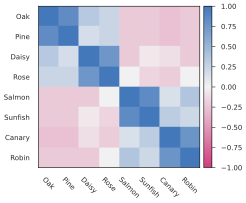

In [7]:
with plt.style.context({ 'axes.grid': False, 'grid.linewidth': 0, 'image.interpolation': 'nearest' }):
    cmap = sns.diverging_palette(-10, 250, as_cmap=True)
    plot_tensor(medium_dataloader.dataset.df.reindex(index=[*palette.keys()]).transpose().corr(), cmap=cmap);
    # plt.savefig('../plots/correlation_matrix')

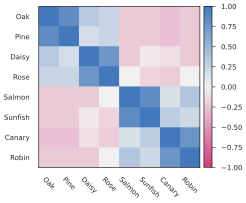

In [8]:
from _work.src.modules.plot import add_colorbar, plot_SVD

with plt.style.context({
    'axes.spines.top': True,
    'axes.spines.right': True,
    "ytick.major.size": 3.5,
    "ytick.major.width": 0.6,
    "ytick.minor.size": 2,
    "axes.linewidth": 0.6,
    "axes.edgecolor": "black",
}):
    tensor = medium_dataloader.dataset.df.reindex(index=[*palette.keys()]).transpose().corr()

    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0, tensor.shape[1], 1))
    ax.set_yticks(np.arange(0, tensor.shape[0], 1))

    for axis in ["top", "bottom", "left", "right"]:
        spine = ax.spines[axis]
        spine.set_visible(True)
        spine.set_linewidth(0.6)
        spine.set_color("black")

    vmax = max(tensor.abs().max())
    
    ax.set_yticklabels(palette.keys())
    ax.set_xticklabels(palette.keys(), rotation=-45)
    ax.tick_params(axis="both", which="both", top=False, bottom=False, left=False, right=False)

    image = ax.imshow(
        tensor,
        cmap=cmap,
        vmin=-vmax,
        vmax=vmax,
        interpolation='nearest',
        # facecolor="white",
        # edgecolors="black",
    );
    add_colorbar(image);
    plt.tight_layout()
    # plt.savefig('../plots/correlation_matrix')

In [3]:
@plt.style.context({
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
})
def plott_svd(df):
    df = df.transpose()
    u, s, vT = np.linalg.svd(df, full_matrices=False)

    first_letters = list(map(lambda x: x[0], df.index))
    modes = list(map(lambda x: x + 1, range(len(df.columns))))

    fig = plt.figure(figsize=(10.5, 3))
    axes = fig.add_gridspec(nrows=1, ncols=4).subplots()

    plot_tensor(df, ax=axes[0])
    axes[0].set_xticklabels(df.columns, rotation=-45)
    axes[0].set_yticklabels(df.index)
    axes[0].set_xlabel("Items")
    axes[0].set_ylabel("Attributes")
    axes[0].set_title("$\Sigma^{yx}$")

    plot_tensor(u, ax=axes[1])
    axes[1].set_yticks(np.arange(0.5, len(first_letters), 1))
    axes[1].set_xticklabels(modes)
    axes[1].set_yticklabels(first_letters)
    axes[1].set_xlabel("Modes")
    axes[1].set_ylabel("Attributes")
    axes[1].set_title("$U$")

    plot_tensor(np.diag(s), ax=axes[2])
    axes[2].set_xticklabels(modes)
    axes[2].set_yticklabels(modes)
    axes[2].set_xlabel("Modes")
    axes[2].set_ylabel("Modes")
    axes[2].set_title("$S$")

    plot_tensor(vT, ax=axes[3])
    axes[3].set_xticklabels(df.columns, rotation=-45)
    axes[3].set_yticklabels(modes)
    axes[3].set_xlabel("Items")
    axes[3].set_ylabel("Modes")
    axes[3].set_title("$V^{T}$")

    for ax in axes:
        ax.tick_params(axis="both", which="both", length=0)

    fig.tight_layout()

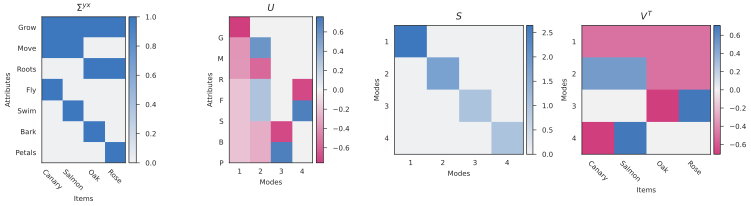

In [9]:
plott_svd(simple_dataloader.dataset.df.rename(columns={'Leaves': 'Bark'}))
plt.savefig('../plots/svd_new_FOR_ILLUSTRATOR')